# Localized Spectral Analysis on the Sphere

A localised spectral estimate is the spectrum of a global function multiplied by a localization window. In a 2D Cartesian coordinate system, this multiplication becomes a convolution in the Fourier domain. As a result of the convolution, a localized spectral estimate for a given wavelength depends upon a range of coefficients of both the global function and localization window. One says that the window *couples* the global Fourier coefficients to the localized coefficients.

Windowing on the sphere leads to similar effects: Multiplication of a global function by a window leads to coupling of the spherical harmonic coefficients of the globally defined function to the localized spectrum. In the case of an isotropic and stationary function, a coupling matrix describes the relation between the global power to the localized power, and at high degrees, this matrix operation resembles a convolution.

## Generate a random model using the SHCoeffs class interface

We first generate a random model using the `SHCoeffs` class interface. This class simplifies coefficient generation and provides a simple access to most SHTOOLS functions. We start by defining a global power spectrum that follows a power-law decay:

In [1]:
%matplotlib inline
from __future__ import print_function # only necessary if using Python 2.x

import matplotlib.pyplot as plt
import numpy as np
from pyshtools.shclasses import SHCoeffs, SHWindow, SHGrid

nl = 100  # l = [0, 199]
lmax = nl - 1
a = 4  # scale length
ls = np.arange(nl, dtype=np.float)
power = 1. / (1. + (ls / a) ** 2) ** 1.5

Next, we generate random coefficients from this input power spectrum, plot the power spectrum of the random realization, and expand the coeffificients on a grid:

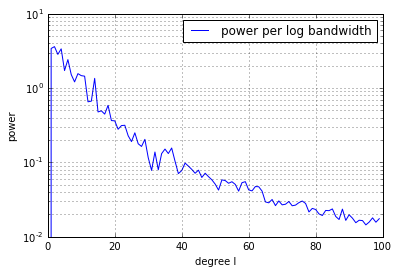

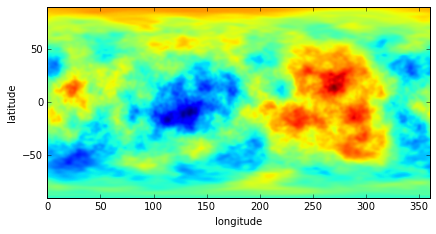

(<matplotlib.figure.Figure at 0x107b94b10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x107cd0fd0>)

In [2]:
coeffs_global = SHCoeffs.from_random(power)

power_global = coeffs_global.spectrum()
coeffs_global.plot_spectrum(unit='per_dlogl')

grid_global = coeffs_global.expand('DH2')
grid_global.plot()

## Generate a box window function

We next generate a window function that picks a few local regions from the globally defined model. In this example, the window contains sharp boundaries, so the spherical harmonic bandwidth of the function is infinite. In general, this could severely bias the localized power spectrum away from its global value, especially when the power spectrum follows a power law. To combat this negative characteristic, we will show in a different tutorial how to construct windows with a specified spherical harmonic bandwith that are optimally concentrated within the provided region.

This example makes use of the class `SHGrid`, which is the counterpart to `SHCoeffs`. Let's start by making an arbitrary mask:

In [3]:
latgrid, longrid = np.meshgrid(grid_global.lats(), grid_global.lons(), indexing='ij')
window = (-40 < latgrid) & (latgrid < -30) & (10 < longrid) & (longrid < 30)
window += (0 < latgrid) & (latgrid < 30) & (60 < longrid) & (longrid < 80)
window += (-70 < latgrid) & (latgrid < -40) & (130 < longrid) & (longrid < 150)
window += (20 < latgrid) & (latgrid < 40) & (125 < longrid) & (longrid < 145)
window += (10 < latgrid) & (latgrid < 30) & (220 < longrid) & (longrid < 250)

Next, generate an `SHGrid` instance from the input array, plot the grid, expand it in spherical harmonics, and calculate and plot the power spectrum. Note that the first element of the grid corresponds to 0 degrees longitude and 90 degrees north.

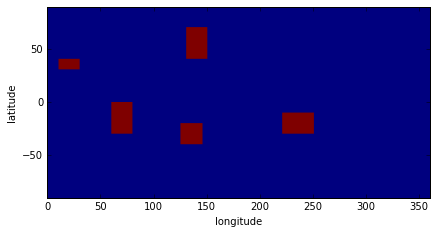

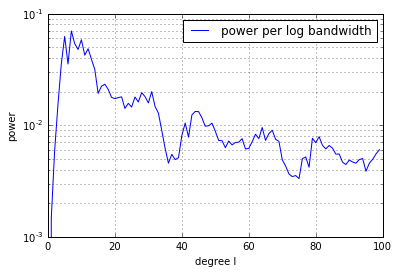

In [4]:
grid_window = SHGrid.from_array(window.astype(np.float64)[::-1])  # DH grid starts at north-pole
grid_window.plot()

coeffs_window = grid_window.expand()
coeffs_window.plot_spectrum(unit='per_dlogl')

power_window = coeffs_window.spectrum()

## Multiply the random model with the window

Multiplication of the global model with the window function localizes the data, and its expansion in spherical harmonics gives a *local* power spectrum estimate. The interaction of the window function with the random model *distorts* the spectrum. In particular, the ouput spectrum at degree `l` is influenced by the input spherical harmonic degrees from `l - Lwin` to `l + Lwin`, where `Lwin` in the spherical harmonic bandwidth of the windowing function.

Let's multiply the data by the window, expand the result in spherical harmonics, and plot the resulting localized power spectrum:

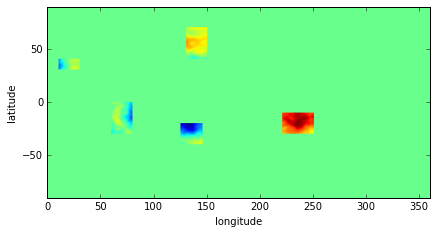

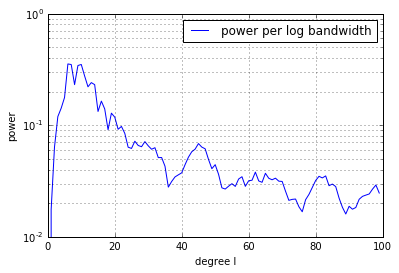

In [5]:
grid_local = SHGrid.from_array(grid_global.data * grid_window.data)
grid_local.plot()

coeffs_local = grid_local.expand()
coeffs_local.plot_spectrum(unit='per_dlogl')

power_local = coeffs_local.spectrum()

## Compute the coupling matrix

The expected distortion of the global spectrum due to the windowing operation can be described by a *coupling matrix* under the assumption that the model is isotropic and stationary. This means that the local (expected) spectra are independent of the position and orientation of the windows. In this case, the expected local spectrum depends only on the power spectrum of the global data and window.

The coupling matrix describes how input power maps to output power. At high degrees, it is approximately symmetric around the diagonal and resembles a convolution in spherical harmonic degree l. At low degrees, however, input power is spread more unevenly into output power. For example, input degree 0 maps preferentially to output degree 4, which is off-diagonal. This is a direct consquence of describing a 2D multiplication with coupling of a single dimension parameter *l*. A similar bias can be seen when describing coupling in 2D Fourier space between coefficients with similar |k|.

Here, we calculate and plot the couplting matrix using the function `SHMTCouplingMatrix`:

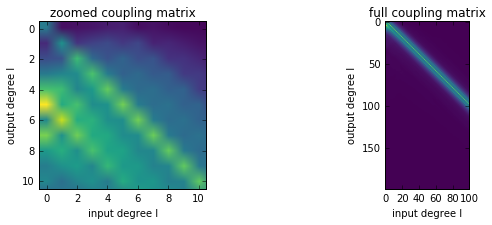

In [6]:
from pyshtools.spectralanalysis import SHMTCouplingMatrix

coupling_matrix = SHMTCouplingMatrix(lmax, power_window.reshape(nl, 1))

fig, (col1, col2) = plt.subplots(1, 2, figsize=(10, 3))
col1.imshow(coupling_matrix, cmap='viridis')
col1.set(xlabel='input degree l', ylabel='output degree l', xlim=(-0.5, 10.5), ylim=(10.5, -0.5),
         title='zoomed coupling matrix');
col2.imshow(coupling_matrix, cmap='viridis')
col2.set(xlabel='input degree l', ylabel='output degree l', title='full coupling matrix');

## Predict the biased spectrum

Finally, the coupling matrix can be used to predict the spectrum of the windowed function. SHTOOLS provides also the functions `SHBiasK` and `SHBias` that can compute directly the biased spectrum without explicitely computing the coupling matrix. Under some assumptions, the coupling matrix can be inverted allowing the global input power spectrum to be estimated from the localized spectrum. This has to be done with care because as a smoothing operation, windowing leads to loss of information (less resolution in degree l space) and has to be regularized to stabilize the inversion.

Here. we compute the biased spectrum using two methods, mutliplication of the global spectrum by the coupling matrix, and the function `SHBias`, and then plot the results.

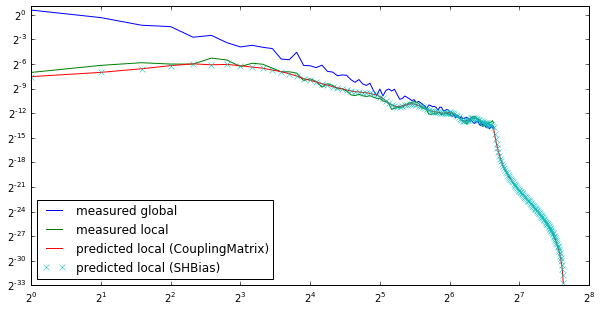

In [7]:
from pyshtools.spectralanalysis import SHBias

power_local2 = np.dot(coupling_matrix, power)
power_local3 = SHBias(power_window, power)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(ls, power_global, label='measured global')
ax.plot(ls, power_local, label='measured local')
ax.plot(power_local2, label='predicted local (CouplingMatrix)')
ax.plot(power_local3, 'x', label='predicted local (SHBias)')
ax.legend(loc=3)
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)